<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Natural Language Processing
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [2]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [3]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
#from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input

C:\Users\fSIoF\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [5]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # the data variable will be a dictionary


In [6]:
# Observing the disponibles fields in every line of the dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [7]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()    
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)
    
    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out
        
        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Number of rows used:", len(input_sentences))

Number of rows used: 6033


In [8]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocessing
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [9]:
# Define the maximun number of words
MAX_VOCABULARY_SIZE = 8000

In [10]:
from keras.preprocessing.text import Tokenizer


# Create tokenizer for the input text and fit it to them
tokenizer_inputs= Tokenizer(num_words=MAX_VOCABULARY_SIZE)
tokenizer_inputs.fit_on_texts(input_sentences)

# Tokenize and transform input texts to sequence of integers
input_integer_seq = tokenizer_inputs.texts_to_sequences(input_sentences)

In [37]:
word2idx_inputs = tokenizer_inputs.word_index
print('Words in the vocabulary', len(word2idx_inputs))

# Calculate the max length
max_input_len = max(len(sentence) for sentence in input_integer_seq )
print('The longest sentence', max_input_len)

Words in the vocabulary 1799
The longest sentence 9


In [12]:
# Check the tokenization
print(input_integer_seq[200])

[22]


In [16]:
# Create tokenizer for the outpu text and fit it to them
#output_tokenizer = Tokenizer(num_words=MAX_VOCABULARY_SIZE, filters='')
output_tokenizer = Tokenizer(num_words=MAX_VOCABULARY_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')

output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)

In [38]:
# Get the word to index mapping for output answer
word2idx_outputs = output_tokenizer.word_index
print('Found %s unique output tokens.' %len(word2idx_outputs))

Found 1806 unique output tokens.


In [19]:
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

In [20]:
# Calculate the max length for the ouput
max_output_len = max(len(sentence) for sentence in output_integer_seq)
print('The longest sentence in the output', max_input_len)

The longest sentence in the output 9


In [39]:
# One is added to include the toke of unknown word
number_word_output = min(len(word2idx_outputs) + 1, MAX_VOCABULARY_SIZE) 

In [40]:
encoder_input_seq = pad_sequences(input_integer_seq, maxlen=max_input_len)
print('Encoder input sequences shape: ', encoder_input_seq.shape)

decoder_input_seq = pad_sequences(output_integer_seq, maxlen=max_output_len, padding='post')
print('Decoder input sequences shape: ', decoder_input_seq.shape)

Encoder input sequences shape:  (6033, 9)
Decoder input sequences shape:  (6033, 10)


In [41]:
#from keras.utils.np_utils import to_categorical
from keras.utils import to_categorical
decoder_output_seq = pad_sequences(output_integer_seq, maxlen=max_output_len, padding='post')

decoder_target = to_categorical(decoder_output_seq, num_classes=number_word_output)
decoder_target.shape

(6033, 10, 1807)

### 3 - Preparing the embeddings
Using the embeddings of Glove or Fastext to transform the input tokens to vectors

Based on subject Natural Language Processing - University of Buenos Aires - Embedded Systems Laboratory

In [42]:
#Download the embeddings
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("The embeddings gloveembedding.pkl have been downloaded yet")

The embeddings gloveembedding.pkl have been downloaded yet


In [43]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dictionary to translate of the embeeding to word idx 
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [27]:
model_embeddings = GloveEmbeddings()

In [44]:
# Making the matrix embedding of the sequences
print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# The word index comes from tokenizer

nb_words = min(MAX_VOCABULARY_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 38


In [45]:
# The embedding size
embedding_matrix.shape

(1799, 50)

### 4 - Training the model
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [46]:
max_input_len

9

In [47]:
n_units = 128

# define training encoder
encoder_inputs = Input(shape=(max_input_len))

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_output_len))
decoder_embedding_layer = Embedding(input_dim=number_word_output, output_dim=n_units, input_length=max_output_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(number_word_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 9)]                  0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 9, 50)                89950     ['input_6[0][0]']             
                                                                                                  
 embedding_3 (Embedding)     (None, 10, 128)              231296    ['input_7[0][0]']             
                                                                                            

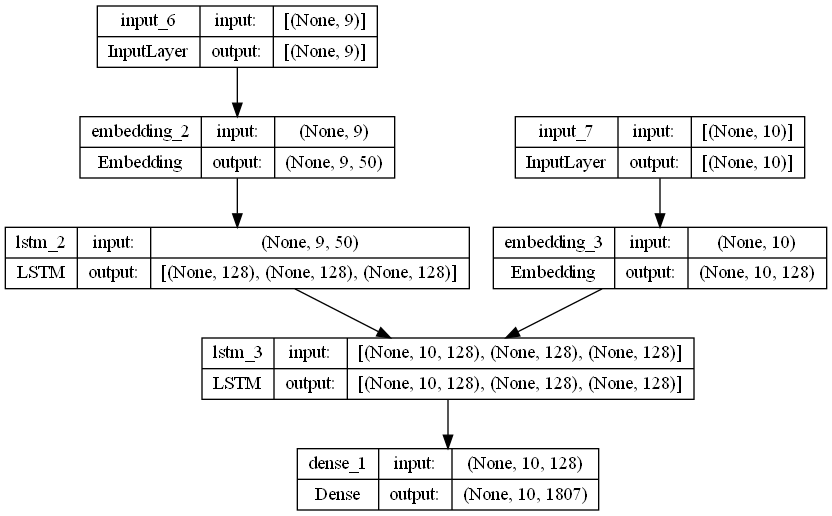

In [48]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

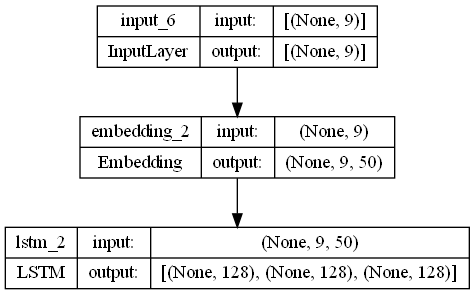

In [49]:
# Model only encoder
encoder_model = Model(encoder_inputs, encoder_states)

from keras.utils import plot_model
plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

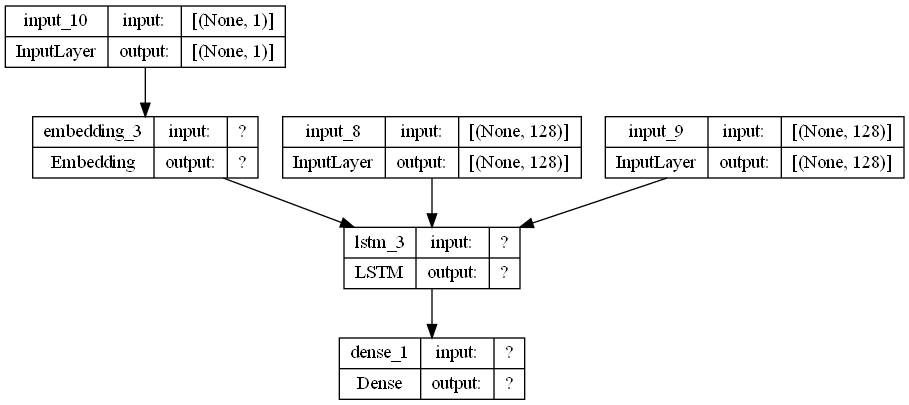

In [50]:
# Model only decoder (for making inferences)
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [51]:
hist = model.fit(
    [encoder_input_seq, decoder_input_seq],
    decoder_target,
    epochs=30, 
    validation_split=0.2)

Epoch 1/30
149/151 [============================>.] - ETA: 0s - loss: 3.0378 - accuracy: 0.5221

InvalidArgumentError: Graph execution error:

Detected at node 'model_3/embedding_2/embedding_lookup' defined at (most recent call last):
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\fSIoF\AppData\Local\Temp\ipykernel_29340\2460976785.py", line 1, in <module>
      hist = model.fit(
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\keras\src\engine\training.py", line 1791, in fit
      val_logs = self.evaluate(
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\keras\src\engine\training.py", line 2200, in evaluate
      logs = test_function_runner.run_step(
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\keras\src\engine\training.py", line 4000, in run_step
      tmp_logs = self._function(dataset_or_iterator)
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\keras\src\engine\training.py", line 1972, in test_function
      return step_function(self, iterator)
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\keras\src\engine\training.py", line 1956, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\keras\src\engine\training.py", line 1944, in run_step
      outputs = model.test_step(data)
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\keras\src\engine\training.py", line 1850, in test_step
      y_pred = self(x, training=False)
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\keras\src\engine\training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\keras\src\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\keras\src\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\fSIoF\anaconda3\envs\nlp_env\lib\site-packages\keras\src\layers\core\embedding.py", line 272, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'model_3/embedding_2/embedding_lookup'
indices[14,8] = 1799 is not in [0, 1799)
	 [[{{node model_3/embedding_2/embedding_lookup}}]] [Op:__inference_test_function_16675]

### 5 - Inference
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.